# Visualization Package
Extremely flexible tool to visualize and debug the data pipeline (data loading, processing, and augmentation ) suitable for machine learning experiments.  The package comes with a rich collection of visualizers and workflows. 

## Terminology

**sample_dict** - Represents a single sample and contains all relevant information about the sample.

No specific structure of this dictionary is required, but a useful pattern is to split it into sections (keys that define a "namespace" ): such as "data", "model",  etc.
NDict (fuse/utils/ndict.py) class is used instead of python standard dictionary in order to allow easy "." seperated access. For example:
`sample_dict[“data.input.img”]` is the equivallent of `sample_dict["data"]["input"]["img"]`

conventions :
1. you should include suffix specifying the type of the value ("img", "seg", "bbox") - which will be used by the type detector ( see VisProbe Op)
2. you can optionaly give a name to your pipeline by sample_dict["name"] = "kits21" and it will show up in every image and file created by the visualizer


## Op(erator)

Operators are the building blocks of the sample processing pipeline. Each operator gets as input the *sample_dict* as created by the previous operators and can either add/delete/modify fields in sample_dict. The operator interface is specified in OpBase class. 
A pipeline is built as a sequence of operators, which do everything - loading a new sample, preprocessing, augmentation, and more.
The visualization tool is integrated in the pipeline using the VisProbe operation

## VisProbe Op
This op can be placed between different steps at the pipeline , it must be used only in the dynamic part of the pipeline
each step can have an optional name which will appear in every image and file created by the visualizer.

This op requires the following inputs in each call :
1. give the input keys that define a "namespace" which included your input ( e.g `sample_dict[“data.input.img”]` and `sample_dict[“data.input.seg"]`)
2. type detector object of class TypeDetectorPatternsBased - used to detect the input type from previous step and convert it to the right class 
3. visualizer - instance of a class that inherits from VisualizerBase ( SaveVisual - to save to nifti file , Imaging2dVisualizer - to save multiple 2d images in one file)
4. output_path - path to save the images
5. VisFlag - indicates what to do in the current step  

    A.  VisFlag.VISUALIZE_CURRENT - visualize only current step 

    B.  VisFlag.COLLECT - save the image in stack and show later

    C.  VisFlag.VISUALIZE_COLLECTED - visualize current step and all collected before it

    D.  VisFlag.CLEAR - clear the stack of collected images

The default behaviour is to save to file the visualization, 
Alternatively you can change to show it online by using original_flag | VisFlag.ONLINE



In [7]:
from functools import partial
import os
import torch

from fuse.data import PipelineDefault, OpToTensor, OpRepeat
from fuseimg.data.ops.aug.geometry import OpAugAffine2D
from fuseimg.data.ops.image_loader import OpLoadImage , OpDownloadImage
from fuseimg.data.ops.color import  OpToRange, OpToIntImageSpace
from fuse.data.ops.ops_visprobe import VisFlag, VisProbe 
from fuse.data.pipelines.pipeline_default import PipelineDefault
from fuseimg.utils.visualization.visualizer import Imaging2dVisualizer
from fuseimg.utils.visualization.visualizer_base import SaveVisual

from fuseimg.data.ops.shape_ops import OpSelectSlice

from fuseimg.utils.typing.key_types_imaging import type_detector_imaging
from fuse.data import PipelineDefault, OpSampleAndRepeat, OpToTensor, OpRepeat

from tempfile import gettempdir
from fuseimg.datasets.kits21 import KITS21
import pathlib
from pycocotools.coco import COCO
from fuse.utils.ndict import NDict

def create_sample_1(views=2):
    data_dir = os.path.join(gettempdir(), "kits21_data")
    KITS21.download(data_dir, cases=[100,200])

    sample = NDict()
    if views >= 1:
        sample['data.viewpoint1.img_filename'] = os.path.join(
            data_dir, 'case_00100/imaging.nii.gz') 
        sample['data.viewpoint1.seg_filename'] = os.path.join(
            data_dir, 'case_00100/aggregated_MAJ_seg.nii.gz')
    for view_idx in range(2,views+1):
        sample[f'data.viewpoint{view_idx }.img_filename'] = os.path.join(
            data_dir, 'case_00200/imaging.nii.gz')
        sample[f'data.viewpoint{view_idx }.seg_filename'] = os.path.join(
            data_dir, 'case_00200/aggregated_MAJ_seg.nii.gz')
    
    return sample , data_dir

## Basic example - using SaveVisual

in each step we call VisProbe with same flag VisFlag.VISUALIZE_CURRENT.

images and segmentation will be saved to the output folder ,
including the given pipe and operation name and the index location in the pipeline

In [6]:
sample , data_dir = create_sample_1(views=1)        
sample["name"] = "kits21_example"
visual = SaveVisual()
VProbe = partial(VisProbe, 
                    keys=  ["data.viewpoint1.img", "data.viewpoint1.seg" ], 
                    type_detector=type_detector_imaging,
                    visualizer = visual, output_path=gettempdir())
repeat_for = [dict(key="data.viewpoint1.img"), dict(key="data.viewpoint1.seg")]
pipeline = PipelineDefault('test_pipeline', [
    (OpLoadImage(data_dir), dict(key_in = 'data.viewpoint1.img_filename', key_out='data.viewpoint1.img', format="nib")),
    (OpLoadImage(data_dir), dict(key_in = 'data.viewpoint1.seg_filename', key_out='data.viewpoint1.seg', format="nib")),
    (OpToIntImageSpace(), dict(key="data.viewpoint1.img") ),
    (OpRepeat(OpToTensor(), kwargs_per_step_to_add=repeat_for), dict(dtype=torch.float32)),
    (VProbe( VisFlag.VISUALIZE_CURRENT , name = "first"), {}),
    (OpToRange(), dict(key="data.viewpoint1.img", from_range=(-500, 500), to_range=(0, 1))),
    (VProbe( VisFlag.VISUALIZE_CURRENT , name = "second"), {}),
    (OpSampleAndRepeat(OpAugAffine2D (), kwargs_per_step_to_add=repeat_for), dict(
        rotate=30.0
    )),
    (VProbe( VisFlag.VISUALIZE_CURRENT, name = "last"), {}),
    
])

sample = pipeline(sample)

100%|██████████| 2/2 [00:00<00:00, 1930.63it/s]


imaging.nii.gz number 100 was found
aggregated_MAJ_seg.nii.gz number 100 was found
imaging.nii.gz number 200 was found
aggregated_MAJ_seg.nii.gz number 200 was found


we can see the following files were created in the running dir

img_first_kits21_example.test_pipeline.4.nii.gz , seg_first_kits21_example.test_pipeline.4.nii.gz 

img_second_kits21_example.test_pipeline.6.nii.gz , seg_second_kits21_example.test_pipeline.6.nii.gz

img_last_kits21_example.test_pipeline.8.nii.gz , seg_last_kits21_example.test_pipeline.8.nii.gz

those files can be opened either by itksnap or NeuroViewer VScode extension

In [8]:
print([file for file in os.listdir(gettempdir()) if "nii.gz" in file])

['img_last_kits21_example.test_pipeline.8.nii.gz', 'img_second_kits21_example.test_pipeline.6.nii.gz', 'seg_second_kits21_example.test_pipeline.6.nii.gz', 'seg_last_kits21_example.test_pipeline.8.nii.gz', 'img_first_kits21_example.test_pipeline.4.nii.gz', 'seg_first_kits21_example.test_pipeline.4.nii.gz']


## multi view example - using Imaging2dVisualizer
in each step we call VisProbe with same flag VisFlag.COLLECT and in the end we call with VisFlag.SHOW_COLLECTED

because we are using ONLINE mode images will be displayed in console.

The follwing example donwloads kits21 image and segmentation and visualize it's rotation and in a specific slice ( so we can use 2d visualizer)


100%|██████████| 2/2 [00:00<00:00, 2207.53it/s]


imaging.nii.gz number 100 was found
aggregated_MAJ_seg.nii.gz number 100 was found
imaging.nii.gz number 200 was found
aggregated_MAJ_seg.nii.gz number 200 was found


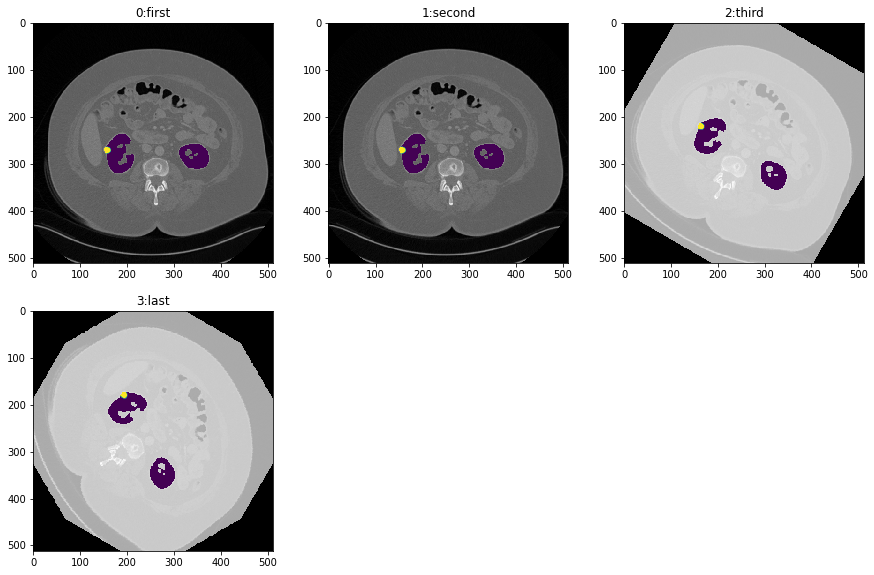

In [5]:
import matplotlib
matplotlib.use('Agg')

sample , data_dir = create_sample_1(views=1)        
sample["name"] = "kits21_example"
visual = Imaging2dVisualizer(cmap = 'gray')
VProbe = partial(VisProbe, 
                    keys=  ["data.viewpoint1.img", "data.viewpoint1.seg" ], 
                    type_detector=type_detector_imaging,
                    visualizer = visual, output_path=gettempdir())
repeat_for = [dict(key="data.viewpoint1.img"), dict(key="data.viewpoint1.seg")]
slice_idx = 190
pipeline = PipelineDefault('test_pipeline', [
    (OpLoadImage(data_dir), dict(key_in = 'data.viewpoint1.img_filename', key_out='data.viewpoint1.img', format="nib")),
    (OpLoadImage(data_dir), dict(key_in = 'data.viewpoint1.seg_filename', key_out='data.viewpoint1.seg', format="nib")),
    (OpSelectSlice(), dict(key="data.viewpoint1.img", slice_idx = slice_idx)),
    (OpSelectSlice(), dict(key="data.viewpoint1.seg", slice_idx = slice_idx)),
    (OpToIntImageSpace(), dict(key="data.viewpoint1.img") ),
    (OpRepeat(OpToTensor(), kwargs_per_step_to_add=repeat_for), dict(dtype=torch.float32)),
    (VProbe( VisFlag.COLLECT , name = "first"), {}),
    (OpToRange(), dict(key="data.viewpoint1.img", from_range=(-500, 500), to_range=(0, 1))),
    (VProbe( VisFlag.COLLECT , name = "second"), {}),
    (OpSampleAndRepeat(OpAugAffine2D (), kwargs_per_step_to_add=repeat_for), dict(
        rotate=30.0
    )),
    (VProbe( VisFlag.COLLECT, name = "third"), {}),
    (OpSampleAndRepeat(OpAugAffine2D (), kwargs_per_step_to_add=repeat_for), dict(
        rotate=30.0
    )),
    (VProbe( flags=VisFlag.VISUALIZE_COLLECTED | VisFlag.ONLINE , name = "last" ), {}),
    
])

sample = pipeline(sample)

## Support for other segmentation types - contour and bounding box
Other segmentation types such as contours and bounding box can also be supported, 
They require special operations to work with them ( e.g rotating , clipping ) while conserving thier type.
These ops are not yet implemented so we show only the the image after loading.

The following example loads some COCO dataset images and segmentations and visualizes them

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!


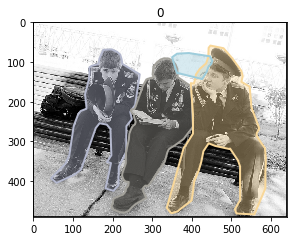

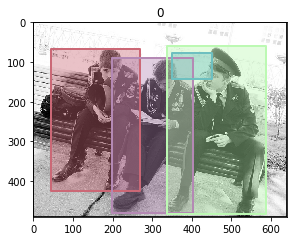

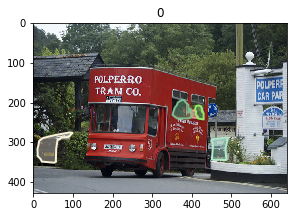

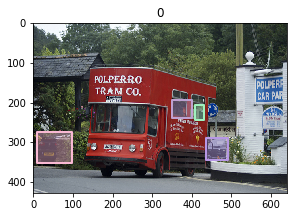

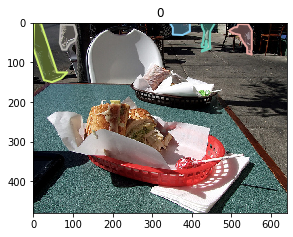

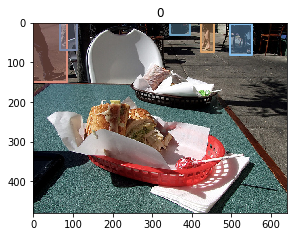

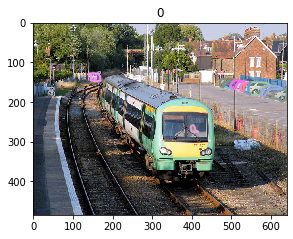

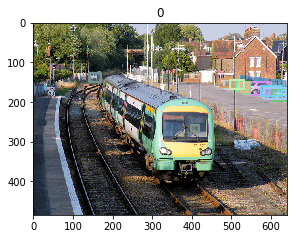

In [7]:
import matplotlib
matplotlib.use('Agg')

visual = Imaging2dVisualizer(cmap = 'gray' )
dir_path = os.getcwd()
annotation_path =os.path.join(dir_path,'tests/inputs/detection/example_coco_new.json')
cocoGt=COCO(annotation_path)
#initialize COCO detections api
resFile=os.path.join(dir_path,'tests/inputs/detection/instances_val2014_fakesegm100_results.json')
coco=cocoGt.loadRes(resFile)
catNms=['person','car']
seg_type_name_map = {'ctr':'segmentation','bbox':'bbox'}
catIds = coco.getCatIds(catNms)
imgIds = coco.getImgIds(catIds=catIds )
for img_id in imgIds:
    for img in coco.loadImgs(ids = [img_id]):
        for segtype in seg_type_name_map.keys() :
            VProbe = partial(VisProbe, 
            keys=  ["data.viewpoint1.img" , "data.viewpoint1."+segtype], 
            type_detector=type_detector_imaging,
            visualizer = visual, output_path=os.getcwd())
            pipeline = PipelineDefault('test_pipeline', [
                    (OpDownloadImage(), dict(key_in ='data.viewpoint1.img_filename', key_out='data.viewpoint1.img')),
                    (VProbe( flags=VisFlag.VISUALIZE_CURRENT | VisFlag.ONLINE ), {}),
                
                ])
            sample_dict = NDict()
            sample_dict['data.viewpoint1.img_filename'] = "http://images.cocodataset.org/val2014/"+img['file_name'] 
            sample_dict["height"] = img['height']
            sample_dict["width"] = img['width']
            sample_dict["name"] = segtype+"_"+img['file_name'] 
            target_annIds = cocoGt.getAnnIds(imgIds=img_id, catIds=[str(id) for id in catIds], iscrowd=None)
            segmentations = []
            for seg in cocoGt.loadAnns(target_annIds) :
                segmentations.append(seg[seg_type_name_map[segtype]])
            sample_dict["data.viewpoint1."+segtype] = segmentations
            sample_dict = pipeline(sample_dict)